# Intro

In [10]:
#Import all packages
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime
import re
import pandas as pd
import numpy as np
import random
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import math
import matplotlib as plt
from matplotlib import pyplot
import altair as alt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

In [12]:
# load Spanish models from spaCy (first download the model: !python -m spacy download es_core_news_sm)
# nlp = spacy.load("es_core_news_sm")
# nlp('Esto es una frase.')

In [13]:
#create a requirements.txt. This puts everything from my base environment. But I don't seem to be able to activate other environments. What about a virtual environment?
# ! pip freeze > requirements.txt

In [14]:
# ! cat requirements.txt

### To-do list
- implement different stopword lists for 1-grams and 2-grams
- include POS features
- include %pro-drop as a feature

- clean up the list of countries ¡Ojo! The country for 'la jurado 10' is wrong. It should be Puerto Rico.
- re-scrape stories formatted incorrectly
- try a decision tree


# Data wrangling

## Radio Ambulante data

### Scraping

In [2]:
#list of all post urls from pg 4

page4 = requests.get('https://radioambulante.org/category/transcripcion/page/4')
soup = BeautifulSoup(page4.text, "lxml")
# print(soup.prettify())

#print one example link from pg. 4
title1 = soup.select('h4.entry-title')[0]
link1 = title1.find('a', href=True)['href']
print(link1)


https://radioambulante.org/transcripcion/transcripcion-los-pibes


In [3]:
#Write a function to get the story links off of any arbitrary page
def get_story_links(pageurl):
    """accept a full url for a page of story results,
    return a list of all 16 story links"""
    page_html = requests.get(pageurl)
    soup = BeautifulSoup(page_html.text, "lxml")
    
    titles = soup.select('h4.entry-title')
    story_links = []
    for title in titles:
        link = title.find('a', href=True)['href']
        story_links.append(link)
    
    return(story_links)

#sanity check: there should be 16 links on pg. 4
print(len(get_story_links('https://radioambulante.org/category/transcripcion/page/4')))

16


In [4]:
#extract country label from story 'el chamán' (2nd link on pg. 4)
el_chaman_url = get_story_links('https://radioambulante.org/category/transcripcion/page/4')[1]
# print(el_chaman_url)
        
el_chaman = requests.get(el_chaman_url)
el_chaman_soup = BeautifulSoup(el_chaman.text, "lxml")
el_chaman_metadata = el_chaman_soup.find(id='ra-meta')
el_chaman_credits = el_chaman_metadata.find_all('p')

for p in el_chaman_credits:
    if 'PAÍS' in p.text:
        el_chaman_country = p.text
        
print(el_chaman_country)

PAÍS
Colombia


In [5]:
#functions to soupify any arbitrary story link and extract country

def soupify(story_link):
    """accept a link and return its text as a BS object"""
    story = requests.get(story_link)
    story_soup = BeautifulSoup(story.text, "lxml")
    
    return story_soup
    
def get_country(story_soup):
    """accept a soupified story, return the country where it was reported"""
    story_metadata = story_soup.find(id='ra-meta')
    story_credits = story_metadata.find_all('p')
    
    country = 'Unknown'
    for p in story_credits:
        if 'PAÍS' in p.text:
            country = p.text[5:]
        else:
            pass
    
    return country

        
#sanity check, the country of el_chaman_url should be Colombia:
print(get_country(soupify(el_chaman_url)))
#sanity check, the country of 'la jorado 10' should be a mistake (Samuel Castaño):
print(get_country(soupify(get_story_links('https://radioambulante.org/category/transcripcion/page/4')[15])))
#sanity check, the country of 'mais médicos' em portugués should be null:
print(get_country(soupify(get_story_links('https://radioambulante.org/category/transcripcion/page/4')[6])))


Colombia
Samuel Castaño
Unknown


In [6]:
#Get country from all stories on page 4
page4_links = get_story_links('https://radioambulante.org/category/transcripcion/page/4')

for story_link in page4_links:
    print(get_country(soupify(story_link)))

Argentina
Colombia
México y Estados Unidos
Estados Unidos
Perú
Argentina
Unknown
Brasil
Colombia
Colombia
Guatemala
Estados Unidos
Perú
Estados Unidos
Chile
Samuel Castaño


In [8]:
#Print the country of each story on the whole Radio Ambulante site

##get list of all pages to scrape 
pages = ['https://radioambulante.org/category/transcripcion/page/'+str(i) for i in range(1,12)]
## first page is: https://radioambulante.org/category/transcripcion
## second page is: https://radioambulante.org/category/transcripcion/page/2
## last page is: https://radioambulante.org/category/transcripcion/page/11

##scrape each page for its links and .extend the list of all_story_links = []
all_story_links = []
for page in pages:
    all_story_links.extend(get_story_links(page))
# print(all_story_links)

##extract country from each story link in all_story_links
countries = [get_country(soupify(story_link)) for story_link in all_story_links]
print(countries)

['España', 'Colombia', 'México', 'Brasil', 'Brasil', 'Chile', 'Nicaragua', 'Ecuador', 'México/Puerto Rico', 'Ecuador', 'Brasil', 'Brasil', 'México/Estados Unidos', 'Guatemala', 'Colombia', 'Guatemala', 'Chile', 'Ecuador', 'Perú', 'Argentina', 'Puerto Rico', 'Perú y Chile', 'Unknown', 'Argentina', 'El Salvador y México', 'Estados Unidos', 'Costa Rica', 'Colombia', 'Colombia', 'Estados Unidos', 'Argentina', 'Ecuador', 'Chile', 'México', 'Unknown', 'Cuba', 'Puerto Rico', 'S\nMéxico y España', 'S\nMéxico y España', 'Venezuela', 'S\nEstados Unidos y Perú', 'Colombia', 'S\nEstados Unidos y Guatemala', 'Costa Rica', 'Colombia y Brasil', 'Colombia', 'Estados Unidos', 'Venezuela', 'Argentina', 'Colombia', 'México y Estados Unidos', 'Estados Unidos', 'Perú', 'Argentina', 'Unknown', 'Brasil', 'Colombia', 'Colombia', 'Guatemala', 'Estados Unidos', 'Perú', 'Estados Unidos', 'Chile', 'Samuel Castaño', 'México', 'Colombia y Costa Rica', 'Estados Unidos', 'España y Perú', 'Perú', 'Chile y Brasil', 'Re

In [10]:
countries_df = pd.DataFrame(countries)
countries_df

,0
0,España
1,Colombia
2,México
3,Brasil
4,Brasil
...,...
165,Guatemala
166,"Tegucigalpa, Honduras"
167,"Nueva York, Estados Unidos"
168,"Puerto Berrio, Colombia"


In [11]:
#How many stories?
print(len(all_story_links))

#How many distinct countries?
print(len(set(countries)))

#How many stories from México?

#How many stories from the Caribbean?

#How many stories from Central America?

#How many stories from Cono Sur?

#How many stories from South America?

#How many storeis from Spain & other areas?

170
54


In [12]:
#Extract transcription from story disparos_al_cielo as a list of (speaker, utterance) tuples

disparos_al_cielo_url ='https://radioambulante.org/transcripcion/disparos-al-cielo-transcripcion'
disparos_al_cielo = requests.get(disparos_al_cielo_url)
disparos_al_cielo_soup = BeautifulSoup(disparos_al_cielo.text, "lxml")
disparos_al_cielo_transcript = disparos_al_cielo_soup.find('div', class_='qode-post-text-main').find_all('p')

speakers = ['']
utterances = ['']
for index,line in enumerate(disparos_al_cielo_transcript):
    #add each line's speaker to the list of speakers
    if line.find('b'):
        speaker = line.find('b').text
    else:
        speaker = speakers[index-1]
    speakers.append(speaker)
    #add each line's utterance to the list of utterances
    if line.find('span'):
        utterance = line.find('span').text
    else:
        utterance = 'NA'
    utterances.append(utterance)
        
disparos_al_cielo_spkr_utt = list(zip(speakers, utterances))
print(disparos_al_cielo_spkr_utt)

[('', ''), ('[Daniel Alarcón, host]:', ' Hola, ambulantes. Antes de comenzar quiero recordarles de nuestro nuevo podcast: El hilo. Es un poco diferente a Radio Ambulante, cada viernes revisamos una noticia importante de Latinoamérica y contamos la historia detrás de esa noticia. Y, claro, en estos días ese tema es coronavirus. El episodio del viernes pasado, por ejemplo, reportamos desde Guayaquil, Ecuador, una de las ciudades más golpeadas de la región. No se lo pierdan.\xa0'), ('', 'Además quiero recordarles que cada viernes por las próximas cinco semanas vamos a poner el episodio de El hilo en este feed. O sea, Radio Ambulante los martes, episodio extra de El hilo los viernes. La idea es servirles mejor durante este periodo tan complejo. Más información en elhilo.audio. OK, entonces aquí va el episodio.'), ('[Daniel Alarcón, host]:', 'Bienvenidos a Radio Ambulante, desde NPR. Soy Daniel Alarcón.\xa0'), ('(SOUNDBITE DE EXPLOSIONES)', 'NA'), ('[Daniel]: ', 'Eso que escuchan se grabó e

In [13]:
#Write a function to extract transcriptions from any arbitrary soupified story
def get_transcription(story_soup):
    """accepts any soupified story and returns its transcription
    as a list of (speaker, utterance tuples)"""
    transcript = story_soup.find('div', class_='qode-post-text-main').find_all('p')
    
    speakers = ['']
    utterances = ['']
    
    #add each line's speaker to the list of speakers
    for index,line in enumerate(transcript):
        if line.find('b'):
            speaker = line.find('b').text #The speaker should be located in a bold text (check this later)
        else:
            speaker = speakers[index-1] #When the speaker is missing, get it from the previous line
            
        speakers.append(speaker)
        
        if line.find('span'): #The utterances should be located in a span tag (check this later)
            utterance = line.find('span').text
        else:
            utterance = 'NA'
            
        utterances.append(utterance)
        
    return list(zip(speakers, utterances))
            
    
#sanity check on disparos_al_cielo
get_transcription(soupify(disparos_al_cielo_url)) == disparos_al_cielo_spkr_utt

True

In [14]:
#Build a dictionary for disparos_al_cielo

disparos_al_cielo_dict = {
    'url': '',
    'title': '',
    'country': '',
    'transcription': []
    }

disparos_al_cielo_dict['url'] = 'https://radioambulante.org/transcripcion/disparos-al-cielo-transcripcion'
disparos_al_cielo_dict['title'] = re.findall(r'transcripcion/(.+)', disparos_al_cielo_dict['url'])

story_soup = soupify(disparos_al_cielo_dict['url']) #this is where the story url gets scraped
disparos_al_cielo_dict['country'] = get_country(story_soup)
disparos_al_cielo_dict['transcription'] = get_transcription(story_soup)

print(disparos_al_cielo_dict)



{'url': 'https://radioambulante.org/transcripcion/disparos-al-cielo-transcripcion', 'title': ['disparos-al-cielo-transcripcion'], 'country': 'México', 'transcription': [('', ''), ('[Daniel Alarcón, host]:', ' Hola, ambulantes. Antes de comenzar quiero recordarles de nuestro nuevo podcast: El hilo. Es un poco diferente a Radio Ambulante, cada viernes revisamos una noticia importante de Latinoamérica y contamos la historia detrás de esa noticia. Y, claro, en estos días ese tema es coronavirus. El episodio del viernes pasado, por ejemplo, reportamos desde Guayaquil, Ecuador, una de las ciudades más golpeadas de la región. No se lo pierdan.\xa0'), ('', 'Además quiero recordarles que cada viernes por las próximas cinco semanas vamos a poner el episodio de El hilo en este feed. O sea, Radio Ambulante los martes, episodio extra de El hilo los viernes. La idea es servirles mejor durante este periodo tan complejo. Más información en elhilo.audio. OK, entonces aquí va el episodio.'), ('[Daniel A

In [15]:
#Build a dictionary for any arbitrary story 
#keys: storyid, url, title, country, transcription (values = a list of (speaker,utterance) tuples)

def process(story_link):
    #Set up the story's dictionary keys with default values
    story_dict = {
        'url': '',
        'title': '',
        'country': '',
        'transcription': []
        }
    
    #Fill in the dictionary's values one by one
    story_dict['url'] = story_link
    story_dict['title'] = re.findall(r'transcripcion/(.+)', story_dict['url'])
    
    #Scrape the story's page ONCE and then parse its country and transcription
    story_soup = soupify(story_dict['url'])
    
    story_dict['country'] = get_country(story_soup)
    story_dict['transcription'] = get_transcription(story_soup)

    return story_dict
    
    
# sanity check on disparos_al_cielo
process('https://radioambulante.org/transcripcion/disparos-al-cielo-transcripcion') == disparos_al_cielo_dict

True

In [16]:
#Process the first 30 stories and put a list of those dictionaries into a cache
cache1 = []
links = [story_link for story_link in all_story_links[:30]]
for link in links:
    cache1.append(process(link))
    
#sanity check first story 
print('juntos-a-la-distancia')
print(cache1[0]['title'])
#sanity check last story
print('transcripcion-soy-marron-2')
print(cache1[-1]['title'])

juntos-a-la-distancia
['juntos-a-la-distancia-transcripcion']
transcripcion-soy-marron-2
['transcripcion-soy-marron-2']


In [17]:
#Process the next 30 stories 
cache2 = []
links = [story_link for story_link in all_story_links[30:60]]
for link in links:
    cache2.append(process(link))
    
#sanity check first story 
print('un-punto-en-el-cielo')
print(cache2[0]['title'])
#sanity check last story
print('postville-iowa')
print(cache2[-1]['title'])

un-punto-en-el-cielo
['un-punto-en-el-cielo-transcripcion']
postville-iowa
['postville-iowa']


In [18]:
#Process the next 30 stories 
cache3 = []
links = [story_link for story_link in all_story_links[60:90]]
for link in links:
    cache3.append(process(link))
    
#sanity check first story 
print('el-hijo')
print(cache3[0]['title'])
#sanity check last story
print('el-area-gris')
print(cache3[-1]['title'])

el-hijo
['transcripcion-el-hijo']
el-area-gris
['transcripcion-el-area-gris']


In [19]:
#Process the next 30 stories 
cache4 = []
links = [story_link for story_link in all_story_links[90:120]]
for link in links:
    cache4.append(process(link))
    
#sanity check first story 
print('a-oscuras')
print(cache4[0]['title'])
#sanity check last story
print('sobrevivientes-2')
print(cache4[-1]['title'])

a-oscuras
['transcripcion-a-oscuras']
sobrevivientes-2
['transcripcion-los-sobrevivientes-2']


In [20]:
#Process the next 30 stories 
cache5 = []
links = [story_link for story_link in all_story_links[120:150]]
for link in links:
    cache5.append(process(link))
    
#sanity check first story 
print('cuando-la-habana-era-friki')
print(cache5[0]['title'])
#sanity check last story
print('mesa-mundial')
print(cache5[-1]['title'])

cuando-la-habana-era-friki
['transcripcion-cuando-la-habana-era-friki']
mesa-mundial
['transcripcion-mesa-mundial']


In [21]:
#Process the last stories 
cache6 = []
links = [story_link for story_link in all_story_links[150:]]
for link in links:
    cache6.append(process(link))
    
#sanity check first story 
print('la-palabra-prohibida')
print(cache6[0]['title'])
#sanity check last story
print('la-caida-del-river')
print(cache6[-1]['title'])

la-palabra-prohibida
['transcripcion-la-palabra-prohibida']
la-caida-del-river
['transcripcion-la-caida-del-river']


In [22]:
#concatenate caches
caches = cache1 + cache2 + cache3 + cache4 + cache5 + cache6

### Cleaning and saving to disk

In [23]:
#check first story
print(caches[0]['title'])
#check last story
print(caches[-1]['title'])
#total stories
print(len(caches))
# #print out all story titles
# for index in range(len(caches)):
#     print(caches[index]['title'])

['juntos-a-la-distancia-transcripcion']
['transcripcion-la-caida-del-river']
170


In [26]:
df = pd.DataFrame(caches)

In [27]:
#Stories that didn't get parsed: 1, 32, 33, 34?, 54, 107?, 114, 125, 135-146, 148, 149?, 150-159, 160-164, 165, 166, 167, 169
df[['url','country','transcription']].iloc[150:170]

,url,country,transcription
150,https://radioambulante.org/transcripcion/trans...,Estados Unidos,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
151,https://radioambulante.org/transcripcion/trans...,Puerto Rico,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
152,https://radioambulante.org/transcripcion/trans...,De Perú a Estados Unidos,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
153,https://radioambulante.org/transcripcion/trans...,México,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
154,https://radioambulante.org/transcripcion/trans...,México,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
155,https://radioambulante.org/transcripcion/trans...,México,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
156,https://radioambulante.org/transcripcion/trans...,Estados Unidos,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
157,https://radioambulante.org/transcripcion/trans...,Estados Unidos,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
158,https://radioambulante.org/transcripcion/trans...,Santiago de Chile,"[(, ), (, NA), (, NA), (, NA), (, NA), (, NA),..."
159,https://radioambulante.org/transcripcion/trans...,México,"[(, ), (, El conductor se bajó del autobús e i..."


In [28]:
#Separate out the bad links for re-processing later on
print(len(caches))
bad_story_indices = [1, 32, 33, 34, 54, 107, 114, 125, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169]
good_urls = []
bad_urls = []

for index, story in enumerate(caches):
    #group urls of the 
    if index in bad_story_indices:
        bad_urls.append(caches[index]['url'])
    else:
#         print(caches[index]['title'], 'is good')
        good_urls.append(caches[index])
    
print(len(good_urls), 'good links remaining')
print(len(bad_urls), 'links to reprocess')


170
129 good links remaining
41 links to reprocess


In [29]:
#unpack dictionaries of GOOD transcriptions
#first, unpack the first transcription into a fully specified df:

#unpack speakers and utterances as columns
story0 = pd.DataFrame(good_urls[0]['transcription'], columns=['speaker', 'utterance'])

#assign a story ID
storyID = ['good-0'] * len(story0)
story0.insert(0, 'storyID', storyID, True) 

#expand the story's url, title, and country into columns of the same length 
url = [good_urls[0]['url']] * len(story0)
story0.insert(1, 'url', url, True)

title = [good_urls[0]['title']] *len(story0)
story0.insert(2, 'title', title, True)

country = [good_urls[0]['country']] *len(story0)
story0.insert(3, 'country', country, True)

In [30]:
#For every other story in good_urls, cast it to a df and vertically append it to the original story
full_df = story0

for index, story in enumerate(good_urls[1:]):
    #print index to assess progress
#     print(index)
    
    #unpack speakers and utterances as columns
    story = pd.DataFrame(good_urls[index]['transcription'], columns=['speaker', 'utterance'])
    
    #assign a story ID
    storyID = ['good-'+ str(index)] * len(story)
    story.insert(0, 'storyID', storyID, True) 

    #expand the story's url, title, and country into columns of the same length 
    url = [good_urls[index]['url']] * len(story)
    story.insert(1, 'url', url, True)

    title = [good_urls[index]['title']] *len(story)
    story.insert(2, 'title', title, True)

    country = [good_urls[index]['country']] *len(story)
    story.insert(3, 'country', country, True)    

    #vertically append to the original story
    full_df = full_df.append(story, ignore_index=True)
    
    
    

In [81]:
# Filter out stories from Brasil or mixed countries
# print(full_df['country'].unique())
keep = ['España', 'México', 'Chile', 'Nicaragua', 'Ecuador',
       'Guatemala','Colombia', 'Perú', 'Argentina', 'Puerto Rico', 'Estados Unidos', 'Costa Rica',
       'Cuba', 'Venezuela', 'República Dominicana', 'El Salvador', 'Honduras', 'Bolivia',
       'Lima, Perú','Uruguay']
drop = ['Brasil', 'México/Puerto Rico', 'México/Estados Unidos', 'Perú y Chile',
       'Unknown', 'El Salvador y México', 'S\nMéxico y España', 'S\nEstados Unidos y Perú', 
        'S\nEstados Unidos y Guatemala','Colombia y Brasil', 'México y Estados Unidos', 
        'Samuel Castaño', 'Colombia y Costa Rica', 'España y Perú', 'Chile y Brasil',
        'S\nEstados Unidos y México', 'S\nMexico y Estados Unidos','S\nCuba/Panamá', 
        'Cuba/Panamá/Estados Unidos', 'Colombia y Argentina', 'México, Estados Unidos', 
        'Rio de Janeiro, Brasil']

['España' 'México' 'Brasil' 'Chile' 'Nicaragua' 'Ecuador'
 'México/Puerto Rico' 'México/Estados Unidos' 'Guatemala' 'Colombia'
 'Perú' 'Argentina' 'Puerto Rico' 'Perú y Chile' 'Unknown'
 'El Salvador y México' 'Estados Unidos' 'Costa Rica' 'Cuba'
 'S\nMéxico y España' 'Venezuela' 'S\nEstados Unidos y Perú'
 'S\nEstados Unidos y Guatemala' 'Colombia y Brasil'
 'México y Estados Unidos' 'Samuel Castaño' 'Colombia y Costa Rica'
 'España y Perú' 'Chile y Brasil' 'República Dominicana' 'El Salvador'
 'Honduras' 'Bolivia' 'S\nEstados Unidos y México'
 'S\nMexico y Estados Unidos' 'S\nCuba/Panamá'
 'Cuba/Panamá/Estados Unidos' 'Lima, Perú' 'Colombia y Argentina'
 'México, Estados Unidos' 'Uruguay' 'Rio de Janeiro, Brasil']


In [112]:
clean_stories = full_df[full_df['country'].isin(keep)]
#how many stories originally?
print(len(full_df['storyID'].unique()))
#How many stories left over?
print(len(clean_stories['storyID'].unique()))

128
100


In [128]:
#Drop rows with blank, or "NA" utterances
clean_stories['utterance'].replace('', np.nan, inplace=True)
clean_stories['utterance'].replace('NA', np.nan, inplace=True)

# Drop rows with blank, "NA", ':', '\n', '.', '. ' or speakers
clean_stories['speaker'].replace('', np.nan, inplace=True)
clean_stories['speaker'].replace('NA', np.nan, inplace=True)
clean_stories['speaker'].replace(':', np.nan, inplace=True)
clean_stories['speaker'].replace('\n', np.nan, inplace=True)
clean_stories['speaker'].replace('.', np.nan, inplace=True)
clean_stories['speaker'].replace('. ', np.nan, inplace=True)

/opt/conda/envs/data3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [129]:
clean_stories.dropna(subset=['utterance', 'speaker'], inplace=True)
clean_stories

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,storyID,url,title,country,speaker,utterance
1,good-0,https://radioambulante.org/transcripcion/junto...,[juntos-a-la-distancia-transcripcion],España,"[Jorge Caraballo, editor de Crecimiento]:","¡Hola, gracias por escuchar Radio Ambulante! N..."
2,good-0,https://radioambulante.org/transcripcion/junto...,[juntos-a-la-distancia-transcripcion],España,"[Daniel Alarcón, host]:","Bienvenidos a Radio Ambulante, desde NPR. Soy ..."
3,good-0,https://radioambulante.org/transcripcion/junto...,[juntos-a-la-distancia-transcripcion],España,"[Jorge Caraballo, editor de Crecimiento]:",Entonces antes de comenzar el episodio de hoy ...
4,good-0,https://radioambulante.org/transcripcion/junto...,[juntos-a-la-distancia-transcripcion],España,"[Daniel Alarcón, host]:",Lo que nos ha llenado de energía y de motivaci...
5,good-0,https://radioambulante.org/transcripcion/junto...,[juntos-a-la-distancia-transcripcion],España,"[Jorge Caraballo, editor de Crecimiento]:",Recuerden que parte del equipo seguirá sacando...
...,...,...,...,...,...,...
26968,good-125,https://radioambulante.org/transcripcion/trans...,[transcripcion-confesion],Estados Unidos,Vanessa Potkin:,Silvia: Ángel no ha sabido nada de la víctima ...
26970,good-125,https://radioambulante.org/transcripcion/trans...,[transcripcion-confesion],Estados Unidos,Vanessa Potkin:,No estoy contra el sistema. Tengo mucha descon...
26972,good-125,https://radioambulante.org/transcripcion/trans...,[transcripcion-confesion],Estados Unidos,Vanessa Potkin:,—
26976,good-125,https://radioambulante.org/transcripcion/trans...,[transcripcion-confesion],Estados Unidos,Vanessa Potkin:,"Camila Segura es nuestra editora principal, y ..."


In [155]:
#clean out speakers that cannot be clearly identified as native speakers of a specific dialect

#regex to identify soundbites and ads
ads = '.*SOUNDBITE.*|.*RISA.*|.*televisión.*|.*All Songs Considered.*|.*Alt.*Latino.*|.*Ask Me Another.*|.*Code.*Switch.*|.*Embedded.*|.*EveryAction.*|.*Fresh Air.*|.*Gene Demby.*|.*Guy.*|.*HBO.*|.*Hanna Rosin.*|.*Hidden Brain.*|.*Planet Money.*|.*How I Built This.*|.*It’s Been a Minute.*|.*Joshua Johnson.*|.*Kelly.*|.*Latino.*USA.*|.*Life Kit.*|.*Linda Holmes.*|.*Lulu.*|.*Lupa.*|.*María Hinojosa.*|.*Matt Holzman.*|.*Mindy Thomas.*|.*NPR Politics.*|.*Ophira Eisenberg.*|.*Peter.*|.*Planet Money.*|.*Pop Culture.*|.*Promo.*|.*Reportero de NPR.*|.*Robin Hilton.*|.*Sam Sanders.*|.*Scott Detrow.*|.*Shereen Marisol Meraji.*|.*Squarespace.*|.*StoryCorps.*|.*TED.*|.*Terry Gross.*|.*The Indicator.*|.*Throughline.*|.*TurboTax.*|.*Up First.*|.*Wait Wait.*|.*Wow in the World.*|.*Here and Now.*' 

#people who probably are speaking English (or a translation of them)
english = '.*Bill.*Clinton.*|.*Cowgirl.*|.*Donald Trump.*|.*Felix Contreras.*|.*Kristjen Nielsen.*|.*Machine.*|.*Malcom X.*|.*Margaret Thatcher.*|.*Martin Luther King.*|.*Neil Armstrong.*|.*Nelson Mandela.*|.*Speaker of the House.*|.*Stacey.*|.*Thomas Homan.*|.*Wolf Blitzer.*|.*John Oliver.*|.*GPS.*|.*Agente de ICE.*|.*Axl Rose.*|.*Bill Spencer.*|.*Ginger.*|.*John Gibler.*|.*Michael Donovan.*|.*Nicole Tyler.*'

#others that I know are misplaced or should be exlcuded
other = '.*Graciela.*|\xa0|\xa0\xa0'

clean_speakers = clean_stories[(clean_stories['speaker'].str.match(ads) == False) & (clean_stories['speaker'].str.match(english) == False) & (clean_stories['speaker'].str.match(other) == False)]

#How many different speakers originally?
print(len(sorted(clean_stories['speaker'].unique())))

#How many different speakers left over?
print(len(clean_speakers['speaker'].unique()))

1432
1275


In [156]:
#Add a dialect column
#Step 1: replace country names with dialect names, using a dictionary
dialectdict = {'España': 'Spain',
               'México': 'Mexican',
               'Chile': 'Chilean', 
               'Nicaragua': 'Nicaraguan', 
               'Ecuador': 'Ecuadorean', 
               'Guatemala': 'Guatemalan',
               'Colombia': 'Colombian', 
               'Perú': 'Peruvian', 
               'Argentina': 'Argentinian', 
               'Puerto Rico': 'Puertorican', 
               'Estados Unidos': 'US',
               'Costa Rica': 'Costarican', 
               'Cuba': 'Cuban', 
               'Venezuela': 'Venezuelan', 
               'República Dominicana': 'Dominican',
               'El Salvador': 'Salvadoran', 
               'Honduras': 'Honduran', 
               'Bolivia': 'Bolivian', 
               'Lima, Perú': 'Peruvian', 
               'Uruguay': 'Uruguayan'
              }
dialects = clean_speakers[['country']].replace(dialectdict)
clean_speakers.insert(4, 'dialect', dialects)

In [157]:
# Step 2: (For now) remove producer and host lines, plus anyone with the same first name
    # (To do): replace producer and host lines with their own dialect
    # host full names are:
    # Vanessa Potkin, Daniel Alarcón, Andrés Azpiri, Camila Segura, Clara Ibarra, 
    # David Trujillo, Dennis Maxwell, Eliezer Budasoff, Gabriela Wiener, Jorge Caraballo, 
    # Lisette Arévalo, Luis Fernando Vargas, Luis Trelles, Mariana Martínez, Silvia Viñas

#regex to identify Radioambulante hosts and producers

hosts = '.*Vanessa.*Potkin.*|.*Daniel.*|.*Andrés.*|.*Camila.*|.*Clara.*|.*David.*|.*Dennis.*|.*Eliezer.*|.*Gabriela.*|.*Jorge.*|.*Lisette.*|.*Luis.*|.*Mariana.*|.*Silvia.*'

radioambulante = clean_speakers[clean_speakers['speaker'].str.match(hosts) == False]

#How many different speakers left over?
print(len(radioambulante['speaker'].unique()))

1091


In [158]:
for speaker in sorted(radioambulante['speaker'].unique())[900:]:
    print(speaker)

[Rafael Escorza]:
[Rafael Martínez]:
[Rafael Samudio]:
[Rafael]:
[Rafael]: 
[Ramón Barrios]: 
[Ramón López]: 
[Ramón]:
[Ramón]: 
[Raquel Villareal]: 
[Ray Charrupí]: 
[Ray]: 
[Raúl Soto]: 
[Raúl]
[Raúl]:
[Raúl]: 
[Recluso]: 
[Remy Lozano]: 
[René Gonzales]:
[René]:
[René]: 
[Reportaje]: 
[Reportera]: 
[Reportero]:
[Reportero]: 
[Rescatista]:
[Rescatista]: 
[Rescatistas]: 
[Residente]: 
[Reyes]: “
[Ricardo García de Alba]: 
[Ricardo Lozano]: 
[Ricardo Rosselló]:
[Ricardo] :
[Ricardo]:
[Ricardo]: 
[Ricardo]:  
[Ricardo  Rosselló]: 
[Rick Nagel]: 
[Rick]: 
[Roberth Pereira]
[Roberth]
[Roberto Ampuero]: 
[Roberto Lozano]: 
[Roberto Zamora]: 
[Roberto]:
[Roberto]: 
[Roberto]: 
[Rocío Figueroa]: 
[Rocío]:
[Rocío]: 
[Rodlin Etienne]: 
[Rodlin]
[Rodlin]: 
[Rodolfo Pérez]:
[Rodolfo]:
[Rodrigo Cid]: 
[Rodrigo Hidalgo]:
[Rodrigo]:
[Rodrigo]: 
[Rogelio Cisneros]: 
[Rogelio]:
[Rogelio]: 
[Roosevelt Rojas]: 
[Roosevelt]:
[Roosevelt]: 
[Rosa Muñoz]: 
[Rosa]:
[Rosa]: 
[Rosi]: 
[Rosina Castillo]: 
[Ros

In [31]:
# #(For now) only use the Mexican speakers from disparos al cielo

# story1 = full_df[(full_df['storyID'] == 'good-1')]
# story1['speaker'].unique()

# #regex expression to identify non-mexican speakers
# nonmex = '.*Victoria.*|.*Daniel.*|.*SOUNDBITE.*|.*Squarespace.*|.*Code Switch.*|.*Up First.*'

# #remove non-mexicans and blank speakers
# mexicans = story1[(story1['speaker'].str.match(nonmex) == False) & (story1['speaker'] != '')]

# #assign dialect column =Mexico
# dialect = ['Mexican'] * len(mexicans)
# mexicans.insert(4, 'dialect', dialect)

In [39]:
#For later: clean up the speaker column using the following dictionary:


# speaker_codes = {'[Daniel Alarcón, host]:' : 'host', 
#                  '[Daniel Alarcón]:' : 'host', 
#                  '[Daniel Alarcon]:' : 'host', 
#                  '[Daniel]:' : 'host', 
#                  '' : 'exclude', 
#                  '[Camila Segura]: 	' : 'editor'}  
  
# # Remap the values of the dataframe to the large df:
# full_df['real_speaker']= full_df['speaker'].map(speaker_codes) 

In [118]:
#(For now) The output dataset is just the one good story df from above
# radioambulante = mexicans

In [160]:
# save radioambulante df to disk
radioambulante.to_csv("radioambulante.csv")


### Read in radioambulante data from disk

In [346]:
#re-read in from disk
radioambulante = pd.read_csv("radioambulante.csv")

## Childes data

In [347]:
#Load the CHILDES dataset as a pandas df
childes = pd.read_csv("childes.csv", low_memory=False)

In [257]:
# childes.info()

## Full dataset

### prep and save to disk

In [348]:
#Add a "source" column to each dataset before merging them

source = ['radioambulante'] *len(radioambulante)
radioambulante.insert(1, 'source', source)

source = ['childes'] *len(childes)
childes.insert(1, 'source', source)

In [349]:
#merge childes to radioambulante on dialect, speaker, and utterance
src_dlct_spkr_utt = [childes[['source','dialect', 'speaker', 'utterance']], radioambulante[['source','dialect', 'speaker', 'utterance']]]
raw_data = pd.concat(src_dlct_spkr_utt)

In [350]:
#Take a look at the full dataset
raw_data

,source,dialect,speaker,utterance
0,childes,Spain,INV-DZIZ,en Oviedo ?
1,childes,Spain,INV-DZIZ,ah (.) es la casa de Sergio (.) sí ?
2,childes,Spain,INV-DZIZ,ah (.) oye (.) y (.) cuántos años tienes ?
3,childes,Spain,INV-DZIZ,dos (.) <a ver> [/] a_ver (.) qué son estos ?
4,childes,Spain,INV-DZIZ,ah (.) tienes tres añitos .
...,...,...,...,...
8543,radioambulante,Mexican,María:,Pues a la vez pues me enorgullezco o lo siento...
8544,radioambulante,Mexican,Carola:,"Por ahora, Jorge sigue con su proyecto, con La..."
8545,radioambulante,Mexican,María:,——–
8546,radioambulante,Mexican,María:,"Y cinco meses después, en julio y en la Ciudad..."


In [351]:
#add a column of dialect REGION (to make the plot below better)
regionsdict = {
                'Spain': 'Spain',
               'Mexican': 'Mexico',
               'Chilean': 'Cono Sur', 
               'Nicaraguan': 'North & Central America', 
               'Ecuadorean': 'South America', 
               'Guatemalan': 'North & Central America',
               'Colombian': 'South America', 
               'Peruvian': 'South America', 
               'Argentinian': 'Cono Sur', 
               'Puertorican': 'Caribbean', 
               'US': 'North & Central America',
               'Costarican': 'North & Central America', 
               'Cuban': 'Caribbean', 
               'Venezuelan': 'Caribbean', 
               'Dominican': 'Caribbean',
               'Salvadoran': 'North & Central America', 
               'Honduran': 'North & Central America', 
               'Bolivian': 'South America', 
               'Uruguayan': 'Cono Sur',
               'Paraguayan': 'Paraguayan',
}
regions = raw_data[['dialect']].replace(regionsdict)
raw_data.insert(2, 'region', regions)


In [352]:
#add a column of dialect values that will be our target. Mexican = 1, everything else = 0

target = list(raw_data['dialect'] == 'Mexican')
raw_data.insert(0, 'target', target)

In [353]:
raw_data.head()

,target,source,dialect,region,speaker,utterance
0,False,childes,Spain,Spain,INV-DZIZ,en Oviedo ?
1,False,childes,Spain,Spain,INV-DZIZ,ah (.) es la casa de Sergio (.) sí ?
2,False,childes,Spain,Spain,INV-DZIZ,ah (.) oye (.) y (.) cuántos años tienes ?
3,False,childes,Spain,Spain,INV-DZIZ,dos (.) <a ver> [/] a_ver (.) qué son estos ?
4,False,childes,Spain,Spain,INV-DZIZ,ah (.) tienes tres añitos .


In [354]:
# save to disk
raw_data.to_csv("raw_data.csv")

### Read in full dataset from disk

In [15]:
#read in full dataset from disk
raw_data = pd.read_csv("raw_data.csv")

# Dialect distribution

In [16]:
#Distribution of utterances from each dialect
# dialects = sorted(raw_data['region'].unique())
dialects = ['\nCaribbean', 'Southern Cone', 'Mexico', '\nNorth \n& Central \nAmerica', 'Paraguay', 'Other South America', 'Spain']
total_utterances = raw_data['region'].value_counts().sort_index()
total_data = sum(total_utterances)
#     colors = ['black', 'beige', 'green', 'lightblue', 'red','blue', 'gold'], 
colors = ['beige', 'lightcoral', 'green', 'grey', 'orange','brown', 'gold']
#     autopct = lambda x: '{:.0f}'.format(x * total_data/100)

## Data by dialect region

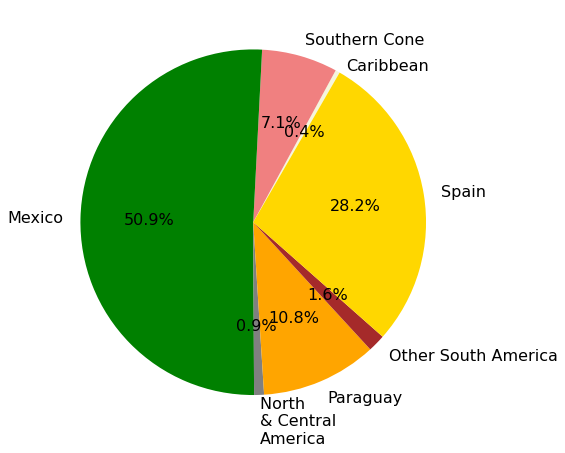

In [17]:
dlctfig = plt.pyplot.figure()
ax = dlctfig.add_axes([0, 0, 1, 2])
pie = ax.pie(total_utterances, labels = dialects, colors = colors, startangle = 60, autopct = '%1.1f%%', textprops={'fontsize': 16})

# Test-train split

In [419]:
# Choose 10% randomly from raw_data dataframe to be the final test set.
n_test = round(.10 * len(raw_data))

test_index = random.sample(list(raw_data.index), n_test)

finaltest = raw_data.loc[raw_data.index.isin(test_index)]
# finaltest.head(25)

remainder = raw_data.loc[~raw_data.index.isin(test_index)]
# remainder.head(25)

# Split the remainder into 60% train and 40% (dev) test set

n_dev = round(.4 *len(remainder))

dev_index = random.sample(list(remainder.index), n_dev)

test = remainder.loc[remainder.index.isin(dev_index)]
# test.head(25)

train = remainder.loc[~remainder.index.isin(dev_index)]
# train.head(25)

In [423]:
# Sanity check that the three dfs are not overlapping
# finaltest.head(25)
# test.head(25)
# train.head(25)

In [424]:
#Make sure that both sets have Mexican and non-Mexican data
print(train['target'].value_counts())
print(test['target'].value_counts())

True     56493
False    50959
Name: target, dtype: int64
False    38937
True     38158
Name: target, dtype: int64


In [433]:
#Save everything to disk
finaltest.to_csv("finaltest.csv")

In [436]:
test.to_csv("test.csv")
train.to_csv("train.csv")

# Feature engineering

### Read in training data from disk (skip to here)

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [19]:
#Separate the input from the output in both cases
train_input = train['utterance']
train_target = train['target']
test_input = test['utterance']
test_target = test['target']

### To do: grammatical encoding and other exclusions

In [100]:
# Next time: try to access the Spanish tokenizer
# nlp = spacy.load("es_core_news_sm")

In [926]:
#Create a grouped list consisting of tokenized utterances from raw_data. 
#THIS TAKES A WHILE
# tokens = [nlp(utt) for utt in raw_data['utterance']]
# tokens

### Stop words

In [21]:
from spacy.lang.es.stop_words import STOP_WORDS as SPACY_STOP_WORDS

len(SPACY_STOP_WORDS)

551

In [22]:
#Remove pronouns and vosotros-conjugated verbs from SpaCy's Spanish stopword list
KEEP = set(['ella', 'ellas', 'ellos', 'él', 'nosotros', 'nosotras', 'tú', 'usted', 'ustedes', 
            'vosotros', 'vosotras', 'yo', 'os', 'vuestra', 'vuestro', 'vuestras', 'vuestros',
            'deprisa', 'empleais', 'eres', 'estais', 'haceis', 'intentais', 'podeis', 'podriais', 
            'sabeis', 'sois', 'soyos', 'teneis', 'trabajais', 'usais', 'vais'])
SPAN_STOP_WORDS = SPACY_STOP_WORDS.difference(KEEP)

In [23]:
#Put names, interjections, and non-words in their own stopword lists
NAMES = set(['mariana','gabriel', 'yaretzi', 'gabi', 'beto', 'hindenburg', 'juan', 'lucía', 'rudy', 'javier', 'ambulante', 'ambulantes', 'lulú', 'lu'])

In [24]:
NONWORDS = set(['sleep', 'number', 'laughs', 'ads', 'cor', 'eng', 'grn', 'jpn', 'xx', 'xxx', 'www', 'snd', 'do', 'to', 'wp', '021100', '021000','020608',
                '0998883339', '0a', '000', '020904', '011127', '020024', '020421', '020316', '020511', '011029',
               '020219, 020709', '020219', '020709', '020121', '020805'])

In [25]:
INTERJECTIONS = set([
 'ahh',
 'aaah',
 'aaaah',
 'ah',
 'ajá', 
 'am',
 'ay',
 'eh',
 'chuk',
 'guau',
 'hm',
 'ja',
 'je',
 'mhm',
 'mmhm',
 'mjm',
 'mm',
 'mmm',
 'mmh',
 'ñam',
 'oh', 
 'oi',
 'oy',
 'padum',
 'ta',
 'tun',
 'uh',
 'ujum',
 'unjú',
 'uy',
 'zumzum'
])


In [26]:
#Put pronouns into their own stopword list for optional inclusion
PRO = set(['ella', 'ellas', 'ellos', 'él', 'nosotros', 'nosotras', 'tú', 'yo'])

In [27]:
#More words for for optional inclusion in stopwords
OTHER = set([
     'siento', 'estabas', 'sabía', 'subir', 'vino', 'feo', 'toca',
    'mesa', 'paso', 'mil', 'hice', 'cama', 'teléfono', 'dejar', 'buscar', 'hombre', 'gustan', 'ropa', 'baño', 'tirar', 'rápido', 'tomar', 'pan', 'difícil', 'ayudo', 'pa',
 'juan', 'cae', 'comprar', 'historia', 'doy', 'amarillo', 'media', 'noche', 'juego', 'pintar', 'ojo', 'espera', 'sacar', 'colores', 'perrito', 'hablando', 'ratito', 'hermano', 'tortuga', 'trae', 'ustedes', 'pie', 'guardar', 'café', 'cabe', 'amigos', 'semana', 'caballo', 'corazón', 'nariz', 'canción', 'fuiste', 'diciendo', 'león', 'tía', 'venir', 'comiendo', 'pasar', 
 'leche', 'cabeza', 'das', 'has', 'lobo', 'gente', 'sale', 'años', 'boca', 'ella', 'nosotros', 'nombre', 'ponemos', 'cosa', 'libro', 'dormir', 'queda', 'pongo', 'comida', 'él', 'tú', 'yo', 'dale', 'come', 'avión', 'coche', 'rojo', 'ellos', 'amor', 'nena', 'señora', 'año', 'hablar', 'rico','a_ver', 've',
 'afuera', 'animales', 'oso', 'meses', 'forma', 'duele', 'aparte', 'sol', 'casita', 'torre', 'entrar', 'quieren', 'hacía', 'alguien', 'corre',
 'oye',
 'ya',
 'abajo',
 'acuerdas',
 'acá',
 'adiós',
 'agua',
 'allá',
 'amigo',
 'azul',
 'bebé',
 'bonita',
 'bonito',
 'caer',
 'casa',
 'cayó',
 'color',
 'comer',
 'con',
 'crees',
 'cuento',
 'cuidado',
 'dame',
 'de',
 'deja',
 'di',
 'dices',
 'diez',
 'digo',
 'dije',
 'dile',
 'dime',
 'el',
 'en',
 'eres',
 'es',
 'escuela',
 'espérame',
 'está',
 'estás',
 'falta',
 'fuerte',
 'gato',
 'gracias',
 'grande',
 'gusta',
 'hiciste',
 'hija',
 'hijo',
 'hola',
 'hora',
 'iba',
 'jugar',
 'la',
 'llama',
 'lo',
 'los',
 'mamá',
 'mano',
 'mañana',
 'me',
 'más',
 'mira',
 'niña',
 'niño',
 'niños',
 'no',
 'padre',
 'papá',
 'pasa',
 'pasó',
 'pero',
 'perro',
 'por',
 'por_favor',
 'porque',
 'puedes',
 'pues',
 'que',
 'quería',
 'quieres',
 'quiero',
 'qué',
 'salir',
 'se',
 'señor',
 'si',
 'siéntate',
 'sí',
 'te',
 'ten',
 'tienes',
 'toma',
 'un',
 'una',
 'vaca',
 'vas',
 'ven',
 'vente',
 'verde',
 'ves',
 'viene',
 'viste', 'vi', 'vuelta', 'rana', 'hermana', 'miedo', 'jugando', 'decía', 'dibujar', 'pon', 'pone', 'cara', 'contar', 'vida', 'visto', 'poquito', 'vale', 'anda', 'salió', 'veo', 'camión'
])


###  Bag-of-words and bag-of-phrases encodings

In [28]:
#Use a variety of different bag-of-words encoding methods

#This is the baseline, vanilla set of one-grams
# vanilla = CountVectorizer(
#     stop_words = SPAN_STOP_WORDS|NONWORDS|INTERJECTIONS|NAMES|PRO,
# )

#This is the best max_features I could get with one-grams
# onegrams = TfidfVectorizer(max_features= 23630,
#                            stop_words = SPAN_STOP_WORDS|NONWORDS|INTERJECTIONS|NAMES|PRO
#                           )

#This is the best max_features I could get with bi-grams
# bigrams = TfidfVectorizer(max_features=77500,
#                            stop_words = SPAN_STOP_WORDS|NONWORDS|INTERJECTIONS|NAMES,
#                            ngram_range=(2,2)
#                           )

#So far this is the best vectorizer overall.
# when including the OTHER stopwords list, it produces lower accuracy but more reasonable results 
cadillac = CountVectorizer(
    stop_words = SPAN_STOP_WORDS|NONWORDS|INTERJECTIONS|NAMES,
    ngram_range=(1,2)
)

#Choose which of the above transformers to use in the model
chosentransformer = cadillac

# Model

## Train a Naive Bayes predictor

In [29]:
#Put together the fitted transformer with a Naive Bayes predictor and fit it on the training data

features = chosentransformer
predictor = MultinomialNB(alpha = 5)

classifier = Pipeline([('features', features),
                     ('predictor', predictor)])


fit_cl = classifier.fit(train_input, train_target)


#After fitting, print some metrics
print("number of observations trained on:", len(train_input))
print("number of features used:", len(features.get_feature_names()))

number of observations trained on: 107452
number of features used: 111415


In [31]:
# pickle the classifier for later use, if needed
dill.dump(fit_cl, open("classifier.pkd", 'wb'))
# dill.dump(all_captions, open('nysd-captions.pkd', 'wb'))

In [32]:
# Re-run the count vectorizer on the training data again, in order to get counts of each feature
# This will be used later to calculate P(word)
#  To do: figure out some way to access the transformed version of 'features' inside of the classifier pipe.
# (Right now all I can do is access the UNtransformed version)
# Consider calling .feature_count_.sum(axis=0) on the predictor IF you can be sure that the counts aren't weighted in some weird way

featurecounts = features.fit_transform(train_input).toarray().sum(axis=0)

## Type sentence, predict dialect

### read in model from dill object

In [35]:
# all_captions = dill.load(open('nysd-captions.pkd', 'rb'))
classifier = dill.load(open("classifier.pkd", 'rb'))

In [38]:
#Create interface for user to make on-the-fly predictions
def classify(text):
    if classifier.predict([text])[0]:
        print("Mexican Spanish!")
    else:
        print("Some other dialect!")

### interactive predictor

In [40]:
classify('vos sos mija')

Some other dialect!


# Feature importance

### code

In [41]:
# #Get P(word|MX) and P(word|non-MX) for all words
# smallcorpus = ['una oración mexicana', 'otra oración mexicana mexicana', 'un enunciado español']
# smalltargets = [1, 1, 0]
# cv = CountVectorizer()
# cv_fit = cv.fit_transform(smallcorpus)
# pred = MultinomialNB()
# pred.fit(cv_fit, smalltargets)

In [42]:
# a = cv.get_feature_names()
# print(a)
# b = cv_fit.toarray().sum(axis=0)
# print(b)
# c = pred.feature_log_prob_[1]
# print(c)
# d = pred.feature_count_.sum(axis=0)
# print(d)

# pd.DataFrame({'a': a, 'b': b, 'c': c, 'd':d})

In [43]:
#Get P(word|MX) and P(word|non-MX) for all words

# Step 1. Get words
words = classifier.named_steps['features'].get_feature_names()

# Step 2. Get each word's count
wordcounts = featurecounts #This was calculated just after the model was fit (see section "Train Naive Bayes predictor")
    #To do: Try to see if this produces the same result EVEN when features get fancier
    # altwordcounts = predictor.feature_count_.sum(axis=0) #

# Step 3. Get each word's log P(word|MX) and log P(word|non-MX) 
logprob_MX = predictor.feature_log_prob_[1] #Pretty sure this is right

logprob_nonMX = predictor.feature_log_prob_[0] #Pretty sure this is right

In [44]:
# Step 4. Put all log probs into a dataframe
featimport_df = pd.DataFrame(
    {'word': words, 
     'count': wordcounts,
#      'altcount': altwordcounts, 
     'logP(word|MX)': logprob_MX, 
     'logP(word|nonMX)':logprob_nonMX
    })

#To do: check if count and altcount produce all the same predictions
# featimport_df['check'] = featimport_df['count'] - featimport_df['altcount']

# featimport_df['check'].sum() == 0

In [45]:
# Step 5. Calculate priors: log P(MX), log P(nonMX) and log P(word)

logpriorMX = predictor.class_log_prior_[1] #This number is right
logpriornonMX = predictor.class_log_prior_[0] #This number is right
totalwords = featimport_df['count'].sum()

featimport_df['logP(word)'] = np.log(featimport_df['count']/totalwords)


# priormex = predictor.class_count_[0]/predictor.class_count_.sum()
# priornonmex = 1- priormex
# print(np.log(priormex))
# print(np.log(priornonmex))
# print(predictor.class_prior)
# print(predictor.class_log_prior_)
# print(predictor.class_count_)

In [46]:
# Step 6. calculate log P(MX|word) and log P(nonMX|word) columns from the previous calculations


featimport_df['logP(MX|word)'] = featimport_df['logP(word|MX)'] + logpriorMX - featimport_df['logP(word)']

featimport_df['logP(nonMX|word)'] = featimport_df['logP(word|nonMX)'] + logpriornonMX - featimport_df['logP(word)']

In [47]:
# Step 7. calculate bare probabilities P(MX|word) and P(nonMX|word)

featimport_df['P(MX|word)'] = np.exp(featimport_df['logP(MX|word)'])
featimport_df['P(nonMX|word)'] = np.exp(featimport_df['logP(nonMX|word)'])

In [48]:
# Step 8. Exclude counts < 100
frequentwds = featimport_df[featimport_df['count'] > 100]

In [49]:
nonmexicanisms = frequentwds.sort_values(by='P(nonMX|word)', ascending=False)
nonmexicanisms.head(25)

,word,count,logP(word|MX),logP(word|nonMX),logP(word),logP(MX|word),logP(nonMX|word),P(MX|word),P(nonMX|word)
46140,guaraní,112,-11.858805,-8.703904,-7.884852,-4.616880,-1.565075,0.009884,0.209072
104805,vení,122,-11.858805,-8.621891,-7.799330,-4.702402,-1.568584,0.009073,0.208340
47980,hala,187,-11.858805,-8.208583,-7.372242,-5.129490,-1.582363,0.005920,0.205489
107351,vo,204,-11.858805,-8.123744,-7.285231,-5.216501,-1.584535,0.005426,0.205043
83193,querés,313,-11.858805,-7.704027,-6.857148,-5.644584,-1.592902,0.003537,0.203335
96281,tenés,258,-11.676483,-7.897733,-7.050391,-5.269019,-1.593365,0.005149,0.203241
107795,vos,453,-11.676483,-7.341395,-6.487459,-5.831952,-1.599958,0.002932,0.201905
64261,mirá,748,-11.858805,-6.842013,-5.985948,-6.515784,-1.602087,0.001480,0.201475
102731,vamo,158,-11.165658,-8.403483,-7.540756,-4.267829,-1.608750,0.014012,0.200138
90577,sapo,150,-11.165658,-8.455443,-7.592716,-4.215869,-1.608750,0.014759,0.200138


In [50]:
mexicanisms = frequentwds.sort_values(by='P(MX|word)', ascending=False)
mexicanisms.head(25)

,word,count,logP(word|MX),logP(word|nonMX),logP(word),logP(MX|word),logP(nonMX|word),P(MX|word),P(nonMX|word)
39720,espérame,109,-8.740855,-11.674318,-7.912003,-1.471779,-4.508338,0.229517,0.011017
111239,órale,190,-8.195243,-11.856640,-7.356327,-1.481844,-5.246336,0.227218,0.005267
110391,ándale,241,-7.962911,-11.856640,-7.118554,-1.487285,-5.484109,0.225985,0.004152
60175,mande,124,-8.631961,-11.386636,-7.783069,-1.491819,-4.349590,0.224963,0.012912
104762,vente,153,-8.431290,-11.268853,-7.572913,-1.501304,-4.441963,0.222839,0.011773
32393,dime,230,-8.034521,-11.068183,-7.165272,-1.512176,-4.648934,0.220430,0.009572
32234,dile,311,-7.734901,-10.981171,-6.863558,-1.514271,-4.863636,0.219969,0.007722
5967,ahorita,439,-7.392897,-10.827021,-6.518852,-1.516973,-5.054192,0.219375,0.006383
104318,ven ven,132,-8.608430,-10.901129,-7.720549,-1.530809,-3.926602,0.216361,0.019711
25729,crees,168,-8.431290,-10.288024,-7.479387,-1.594831,-3.554660,0.202943,0.028591


In [51]:
#Create a figure displaying the top 10 words that predict MX
data = mexicanisms.head(10)

#add translations, for an English-speaking audience
translation = ['"hold on"', '"wow!"', '"hurry up"', '"come again?"', '"come here"', '"tell me"', '"tell them"', '"in a sec"', '"come, come"', '"(do you) think"']
data.insert(0, 'translation', translation)

In [52]:
data['word/translation'] = data[['translation','word']].agg(':   '.join, axis=1)

/home/jovyan/conda-envs/capstone-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
data

,translation,word,count,logP(word|MX),logP(word|nonMX),logP(word),logP(MX|word),logP(nonMX|word),P(MX|word),P(nonMX|word),word/translation
39720,"""hold on""",espérame,109,-8.740855,-11.674318,-7.912003,-1.471779,-4.508338,0.229517,0.011017,"""hold on"": espérame"
111239,"""wow!""",órale,190,-8.195243,-11.856640,-7.356327,-1.481844,-5.246336,0.227218,0.005267,"""wow!"": órale"
110391,"""hurry up""",ándale,241,-7.962911,-11.856640,-7.118554,-1.487285,-5.484109,0.225985,0.004152,"""hurry up"": ándale"
60175,"""come again?""",mande,124,-8.631961,-11.386636,-7.783069,-1.491819,-4.349590,0.224963,0.012912,"""come again?"": mande"
104762,"""come here""",vente,153,-8.431290,-11.268853,-7.572913,-1.501304,-4.441963,0.222839,0.011773,"""come here"": vente"
32393,"""tell me""",dime,230,-8.034521,-11.068183,-7.165272,-1.512176,-4.648934,0.220430,0.009572,"""tell me"": dime"
32234,"""tell them""",dile,311,-7.734901,-10.981171,-6.863558,-1.514271,-4.863636,0.219969,0.007722,"""tell them"": dile"
5967,"""in a sec""",ahorita,439,-7.392897,-10.827021,-6.518852,-1.516973,-5.054192,0.219375,0.006383,"""in a sec"": ahorita"
104318,"""come, come""",ven ven,132,-8.608430,-10.901129,-7.720549,-1.530809,-3.926602,0.216361,0.019711,"""come, come"": ven ven"
25729,"""(do you) think""",crees,168,-8.431290,-10.288024,-7.479387,-1.594831,-3.554660,0.202943,0.028591,"""(do you) think"": crees"


## fig: keywords for Alexa

In [55]:

predictMX = alt.Chart(data).mark_bar().encode(
    x = 'P(MX|word)',
    y = alt.Y('word/translation:N', sort = '-x', title=None)
).properties(title="Strongest predictors of Mexican Spanish"
).configure_title(fontSize=24
).configure_axis(
    titleFontSize=12,
    labelFontSize=16
)

In [56]:
predictMX

alt.Chart(...)

### P(word|dialect) [consider deleting]

In [57]:
#Get the top ten most probable words in Mex and non-Mex dialects
mex_indices = predictor.feature_log_prob_[1].argsort()[::-1][:10]
mex_words = list(np.take(features.get_feature_names(), mex_indices))

nonmex_indices = predictor.feature_log_prob_[0].argsort()[::-1][:10]
nonmex_words = list(np.take(features.get_feature_names(), nonmex_indices))

print('top Mexicanisms:')
print(mex_words)
print('\ntop Non-Mexicanisms:')
print(nonmex_words)

#Measure how much overlap there is between these lists
def prop_overlap(l1, l2):
    """calculate proportion of overlap between elements of 
    l1 and l2, which are lists of equal length"""
    set1 = set(l1)
    set2 = set(l2)
    
    overlap = set1.intersection(set2)
    prop = len(overlap)/len(set1)
    return prop
  
print(f"\nDegree of overlap: {prop_overlap(mex_words, nonmex_words)}")    

print("overlapping elements:")
print(set(mex_words).intersection(nonmex_words))

top Mexicanisms:
['mira', 'a_ver', 'yo', 'tú', 'vas', 'quieres', 'ven', 'oye', 'acá', 'llama']

top Non-Mexicanisms:
['yo', 'mira', 'acá', 'mirá', 'vas', 'a_ver', 'quieres', 'venga', 'mamá', 'tú']

Degree of overlap: 0.7
overlapping elements:
{'tú', 'mira', 'acá', 'a_ver', 'vas', 'quieres', 'yo'}


In [58]:
#Create df of top ten mexicanisms and their conditional probabilities
mex_logprobs = predictor.feature_log_prob_[1]
mex_names = features.get_feature_names()
mex_topten = sorted(zip(mex_logprobs, mex_names), reverse = True)[:10]


mex_wordprob = pd.DataFrame(mex_topten, columns= ['log_probability' , 'word'])
mex_wordprob['P(word|Mexican)'] = np.exp(mex_wordprob['log_probability'])
# np.exp(mex_wordprob['log_probability'])
mex_wordprob

,log_probability,word,P(word|Mexican)
0,-5.606516,mira,0.003674
1,-5.658701,a_ver,0.003487
2,-5.930280,yo,0.002658
3,-6.359999,tú,0.001729
4,-6.468820,vas,0.001551
5,-6.617058,quieres,0.001337
6,-6.752859,ven,0.001168
7,-6.940285,oye,0.000968
8,-7.088120,acá,0.000835
9,-7.337016,llama,0.000651


###### figure

In [59]:
data = mex_wordprob

alt.Chart(data).mark_bar().encode(
    x = 'P(word|Mexican):Q',
    y = alt.Y('word:N', sort = '-x')
).properties(title="Words most common in Mexican Spanish"
).configure_title(fontSize=24
).configure_axis(
    titleFontSize=12,
    labelFontSize=16
)

alt.Chart(...)

# Model performance

### confusion matrix

In [60]:
#Fit the model on the (dev) test set
predictions = classifier.predict(test_input)

In [61]:
# calculate the confusion matrix: 

tn, fp, fn, tp = confusion_matrix(test_target, predictions).ravel()

In [62]:
# calculate precision and recall 
print(f'Precision ({tp} True positives vs. {fp} False positives): {round(tp/(tp+fp)*100, 2)}%'
      + '\n'
      + f'Recall ({tp} True positives vs. {fn} False negatives): {round(tp/(tp+fn)*100, 2)}%')

Precision (33593 True positives vs. 20181 False positives): 62.47%
Recall (33593 True positives vs. 4565 False negatives): 88.04%


## fig: Better performance with Mexican Spanish

In [63]:
#visualize accuracy
performance = {"count": [tp, fp, tn, fn], 
               "correct prediction?": ["yes", "no", "yes", "no"],
               "correctness": ["correct", "incorrect", "correct", "incorrect"],
               "dialect": ["Mexican", "Other dialects", "Other dialects", "Mexican"]}

performance = pd.DataFrame(performance)

In [64]:
performancechart = alt.Chart(performance).mark_bar().encode(
    y = alt.Y('dialect:N', title=None),
    x = alt.X('count:Q', stack='normalize', title=None),
    color = 'correct prediction?:N'
).properties(title="Overall accuracy"
).configure_title(fontSize=24
).configure_axis(
    titleFontSize=12,
    labelFontSize=16
)

In [65]:
performancechart

alt.Chart(...)

### performance by sentence length

In [71]:
#Create a dataframe comparing predictions to target on THE TEST DATA
sntc_perf = pd.DataFrame(zip(test_input, predictions, test_target), columns=['test_sentence', 'prediction', 'target'])

In [72]:
# Insert a column for sentence length
length = [len(sentence.split()) for sentence in sntc_perf['test_sentence']]
sntc_perf.insert(1, 'length', length)

In [73]:
#Split by sentence length (extra-short: 1-3, short: 4-8, mid: 8-20, long: 21-33, extra-long: 34+)
labs = ['x_short', 'short', 'mid', 'long', 'x_long']
bins =[0, 3, 8, 20, 33, 500]
sntc_perf['cat_length'] = pd.cut(sntc_perf['length'], bins=bins, labels=labs)

sntc_perf.head(10)

,test_sentence,length,prediction,target,cat_length
0,en Oviedo ?,3,False,False,x_short
1,dos (.) <a ver> [/] a_ver (.) qué son estos ?,11,True,False,mid
2,sí [/] sí .,4,True,False,short
3,muy bien .,3,True,False,x_short
4,venga .,2,False,False,x_short
5,claro (.) a qué es chulo (.) eh ?,9,False,False,mid
6,está ya puesta (.) venga (.) me vas a contar e...,13,False,False,mid
7,venga (.) ven (.) ven (.) ven !,8,True,False,short
8,te lo voy a contar (.) venga .,8,False,False,short
9,se lo pides a (.) mamá .,7,False,False,short


In [74]:
#Calculate confusion matrices by sentence length

lengths = labs #each different sentence length
n = [] #number of sentences of each length
precision = [] #precision at this length
recall = [] #recall at this length

for interval in lengths:
    df = sntc_perf[sntc_perf['cat_length'] == interval]
    tn, fp, fn, tp = confusion_matrix(df['target'], df['prediction']).ravel()
    precision.append(round(tp/(tp+fp), 2))
    recall.append(round(tp/(tp+fn), 2))
    n.append(sum([tn, fp, fn, tp]))
 
# zip them all up into a df

perf_by_length = pd.DataFrame(zip(lengths, n, precision, recall), columns=['length', 'n', 'precision', 'recall'])

In [75]:
perf_by_length

,length,n,precision,recall
0,x_short,25649,0.56,0.94
1,short,35909,0.65,0.86
2,mid,12108,0.73,0.83
3,long,1890,0.71,0.78
4,x_long,1534,0.59,0.65


In [76]:
# visualize performance and recall by sentnece length
length_in_words = pd.Series(['1-3', '4-8', '8-20', '21-33', '34+']) 
data = perf_by_length[['precision', 'recall']]
data.insert(0, 'sentence_length', length_in_words)
data = pd.melt(data, id_vars='sentence_length', value_vars=['precision', 'recall'])
data

,sentence_length,variable,value
0,1-3,precision,0.56
1,4-8,precision,0.65
2,8-20,precision,0.73
3,21-33,precision,0.71
4,34+,precision,0.59
5,1-3,recall,0.94
6,4-8,recall,0.86
7,8-20,recall,0.83
8,21-33,recall,0.78
9,34+,recall,0.65


In [77]:
performancebylength = alt.Chart(data).mark_line().encode(
    x=alt.X('sentence_length', sort=list(length_in_words)),
    y='value',
    color='variable'
).properties(
    width=400,
    height=200
)

In [78]:
performancebylength

alt.Chart(...)

In [79]:
#re-graph accuracy, excluding sentences with 3 words or less
long_test_sentences = sntc_perf[sntc_perf['length'] > 3]
long_test_sentences

,test_sentence,length,prediction,target,cat_length
1,dos (.) <a ver> [/] a_ver (.) qué son estos ?,11,True,False,mid
2,sí [/] sí .,4,True,False,short
5,claro (.) a qué es chulo (.) eh ?,9,False,False,mid
6,está ya puesta (.) venga (.) me vas a contar e...,13,False,False,mid
7,venga (.) ven (.) ven (.) ven !,8,True,False,short
...,...,...,...,...,...
77089,"Pórtense bien, todos sabemos quiénes andan en ...",9,False,True,mid
77090,Vamos a sacudir el árbol y se van a caer mucha...,52,False,True,x_long
77091,Con el alcalde Cruz y los cinco policías libre...,34,False,True,x_long
77092,"A la mamá de Jorge, María, la viuda de Moisés...",21,True,True,long


In [80]:
#Calculate accuracy with the confusion matrix
tn, fp, fn, tp = confusion_matrix(long_test_sentences['target'], long_test_sentences['prediction']).ravel()

In [84]:
#visualize accuracy
longperformance = {"count": [tp, fp, tn, fn], 
               "correct prediction?": ["yes", "no", "yes", "no"],
               "correctness": ["correct", "incorrect", "correct", "incorrect"],
               "dialect": ["Mexican", "Other dialects", "Other dialects", "Mexican"]}

longperformance = pd.DataFrame(longperformance)

In [85]:
longperformance

,count,correct prediction?,correctness,dialect
0,21527,yes,correct,Mexican
1,10667,no,incorrect,Other dialects
2,15463,yes,correct,Other dialects
3,3784,no,incorrect,Mexican


In [86]:
longer_performancechart = alt.Chart(longperformance).mark_bar().encode(
    y = alt.Y('dialect:N', title=None),
    x = alt.X('count:Q', stack='normalize', title=None),
    color = 'correct prediction?:N'
).properties(title="Sentences with at least 3 words"
).configure_title(fontSize=24
).configure_axis(
    titleFontSize=12,
    labelFontSize=16
)

### performance with ≥ 3 words

In [87]:
longer_performancechart

alt.Chart(...)